# Homework 2 Part 1 - Behavior Cloning and Offline RL

***

Written by Albert Wilcox

In this homework, you'll implement DAgger and Implicit Q learning on the `halfcheetah-medium-replay-v2` task from the [D4RL benchmark](https://github.com/Farama-Foundation/D4RL).

First, in the top right corner make sure you're connected to a T4 GPU since those are the only runtimes we tested these instructions on.

Next, Upload the folder 'hw2' from the Git repo into your Google Drive.

Finally, ensure that the paths in the following cell are correct and run the following cells to set up your Colab environment and install the necessary requirements. Note that for Colab you do this instead of dealing with the conda environment.

In [5]:
import os
import sys
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/hw2')
sys.path.append('/content/drive/MyDrive/hw2')

Mounted at /content/drive


In [6]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libopengl-dev libosmesa6
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgl1-mesa-glx libgles-dev libgles1 libglew-dev
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev libosmesa6
  libosmesa6-dev
0 upgraded, 15 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,020 kB of archives.
After this operation, 19.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1 [101 kB]
Get:3 http://archive.ubuntu.com/ubuntu 

Now run the following cell. Everything should import correctly.|

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

import gym
import numpy as np
from loguru import logger
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm
import einops
import os
import copy

from src.utils import (
    get_device,
    set_seed,
    eval_policy,
    demo_policy,
    plot_returns,
    save_frames_as_gif,
    update_exponential_moving_average,
    return_range
)
from src.d4rl_dataset import D4RLSampler

plt.ion()

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

***

### Part 0 - Setting up D4RL and Dataset

The first step for training on the D4RL benchmark is to set up the environment. Unfortunately mujoco can be difficult to install. Run the following block to test your install. If you have any issues, Google is your friend :)

In [8]:
import d4rl

/usr/local/lib/python3.10/dist-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group


Compiling /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx


INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib/python3.10/dist-packages/mujoco_py
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib/python3.10/dist-packages/mujoco_py/gl
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.10/dist-packages/mujoco_py -I/usr/local/lib/python3.10/dist-packages/mujoco_py/binaries/linux/mujoco210/include -I/usr/local/lib/python3.10/dist-packages/numpy/core/include -I/usr/include/python3.10 -c /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.c -o /usr/local/lib/python3.10/dist-packages/mujoco_py/g

Next we need to initialize our environment and set the random seed for a variety of libraries in order to ensure determinism in our experiments.

For this homework we'll be using the `halfcheetah-medium-replay-v2` environment. This environment involves training a two-legged cheetah to run, and comes with a dataset that consists of data from rolling out a suboptimal SAC agent and exploration data from the SAC replay buffer. Thus, it comes from a wide distribution of policies and contains a good amount of suboptimal data.

In [9]:
SEED: int = 42
ENVIRONMENT_NAME: str='halfcheetah-medium-replay-v2'

# torch related defaults
DEVICE = get_device()
torch.set_default_dtype(torch.float32)

# Use random seeds for reproducibility
set_seed(SEED)

# instantiate the environment
env = gym.make(ENVIRONMENT_NAME)

# get the state and action dimensions
action_dimension = env.action_space.shape[0]
state_dimension = env.observation_space.shape[0]

logger.info(f'Action Dimension: {action_dimension}')
logger.info(f'Action High: {env.action_space.high}')
logger.info(f'Action Low: {env.action_space.low}')
logger.info(f'State Dimension: {state_dimension}')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2024-11-11 19:30:01.469 | INFO     | src.utils:get_device:52 - Using cuda device.
2024-11-11 19:30:01.776 | INFO     | src.utils:set_seed:38 - Random seed set as 42.
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
2024-11-11 19:30:01.791 | INFO     | __main__:<cell line: 18>:18 - Action Dimension: 6
2024-11-11 19:30:01.794 | INFO     | __main__:<cell line: 19>:19 - Action High: [1. 1. 1. 1. 1. 1.]
2024-11-11 19:30:01.796 | INFO     | __main__:<cell line: 20>:20 - Action Low: [-1. -1. 

Next, we need a dataset. Luckily for us, D4RL provides datasets that are convenient to download and train on. Running the following command should download and cache the dataset and initialize a dataset object before printing out some useful information.

In [10]:
dataset = d4rl.qlearning_dataset(env)

logger.info(f'Dataset type: {type(dataset)}')
logger.info(f'Dataset keys: {dataset.keys()}')
logger.info(f'# Samples: {len(dataset["observations"])}')

load datafile: 100%|██████████| 11/11 [00:00<00:00, 25.55it/s]
2024-11-11 19:30:09.208 | INFO     | __main__:<cell line: 3>:3 - Dataset type: <class 'dict'>
2024-11-11 19:30:09.210 | INFO     | __main__:<cell line: 4>:4 - Dataset keys: dict_keys(['observations', 'actions', 'next_observations', 'rewards', 'terminals'])
2024-11-11 19:30:09.213 | INFO     | __main__:<cell line: 5>:5 - # Samples: 201798


In this cell we wrap the D4RL dataset in a sampler. You can comment out the lines at the bottom to make sure everything runs smoothly.

In [11]:

sampler = D4RLSampler(dataset, 256, DEVICE)

# Uncomment the following lines to iterate through the datset and make sure everything runs smoothly
# for _ in tqdm(sampler):
#     pass

### Part 1 - Behavior Cloning

In this part of the homework you'll implement behavior cloning.

Next, train a BC agent by minimizing the negative log likelihood (NLL) of the predicted distribution on datset actions.

You should achieve a maximum normalized reward greater than 0.35 with the provided hyperparameters.

100%|██████████| 789/789 [00:02<00:00, 349.18it/s]
2024-11-11 17:12:08.015 | INFO     | __main__:<cell line: 19>:50 - Epoch: 5. Loss: 0.0000. Reward: 0.2683 +/- 0.0925
100%|██████████| 789/789 [00:02<00:00, 352.30it/s]
2024-11-11 17:12:57.923 | INFO     | __main__:<cell line: 19>:50 - Epoch: 10. Loss: 0.0000. Reward: 0.3125 +/- 0.1134
100%|██████████| 789/789 [00:02<00:00, 318.31it/s]
2024-11-11 17:13:49.036 | INFO     | __main__:<cell line: 19>:50 - Epoch: 15. Loss: 0.0000. Reward: 0.3511 +/- 0.0767
100%|██████████| 789/789 [00:02<00:00, 311.42it/s]
2024-11-11 17:14:38.480 | INFO     | __main__:<cell line: 19>:50 - Epoch: 20. Loss: 0.0000. Reward: 0.3622 +/- 0.0867
100%|██████████| 789/789 [00:02<00:00, 352.76it/s]
2024-11-11 17:15:28.310 | INFO     | __main__:<cell line: 19>:50 - Epoch: 25. Loss: 0.0000. Reward: 0.3552 +/- 0.0887
100%|██████████| 789/789 [00:02<00:00, 357.78it/s]
2024-11-11 17:16:18.258 | INFO     | __main__:<cell line: 19>:50 - Epoch: 30. Loss: 0.0000. Reward: 0.362

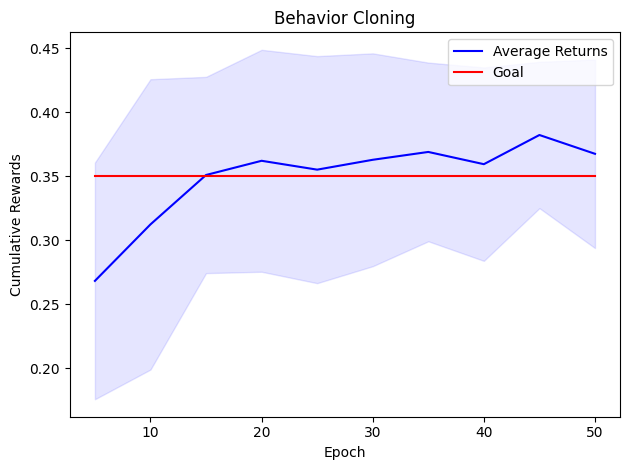

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
from src.networks import GaussianPolicy

################################## Hyper-parameters #########################################

EPOCHS: int = 50
EVAL_FREQ = 5
LOAD_CKPT = False

hidden_dim: int = 256
n_hidden: int = 3
lr: float = 3e-4
WEIGHT_DECAY: float = 3e-4

#############################################################################################

bc_policy = GaussianPolicy(state_dimension, action_dimension, hidden_dim, n_hidden).to(DEVICE)
optimizer = Adam(bc_policy.parameters(), lr)

if LOAD_CKPT and os.path.exists('bc_policy.pth'):
    ckpt = torch.load('bc_policy.pth')
    bc_policy.load_state_dict(ckpt['state_dict'])
    means = ckpt['means']
    stds = ckpt['stds']
else:
    means, stds = [], []
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in tqdm(sampler):
            state = batch['state'].to(DEVICE)
            action = batch['action'].to(DEVICE)

            # TODO: compute negative log likelihood loss on this batch
            # loss = torch.tensor(0)

            # total_loss += loss.item()
            # Forward pass to get the action distribution
            policy = bc_policy.pi(state)

            # Calculate NLL loss
            log_prob = policy.log_prob(action).sum(dim=-1)  # Sum log probs across action dimensions
            loss = -log_prob.mean()  # Negative log-likelihood

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % EVAL_FREQ == 0:
            rew_mean, rew_std = eval_policy(bc_policy, environment_name=ENVIRONMENT_NAME, eval_episodes=50)
            logger.info(f'Epoch: {epoch + 1}. Loss: {total_loss / len(sampler):.4f}. Reward: {rew_mean:.4f} +/- {rew_std:.4f}')
            means.append(rew_mean)
            stds.append(rew_std)
    # Save the policy and learning curve in case there is an issue so you can plot without retraining
    exp_state = {
        'state_dict': bc_policy.state_dict(),
        'means': means,
        'stds': stds
    }
    torch.save(exp_state, 'bc_policy.pth')
epochs = np.arange(EVAL_FREQ, EPOCHS + EVAL_FREQ, step=EVAL_FREQ)
plot_returns(means, stds,'Behavior Cloning', epochs=epochs, goal=0.35)

Now that we've finished training, use the following block to visualize the policy you trained with BC.

<ipython-input-13-6c244a290b66>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bc_policy.load_state_dict(torch.load('bc_policy.pth')['state_dict'])
100%|██████████| 200/20

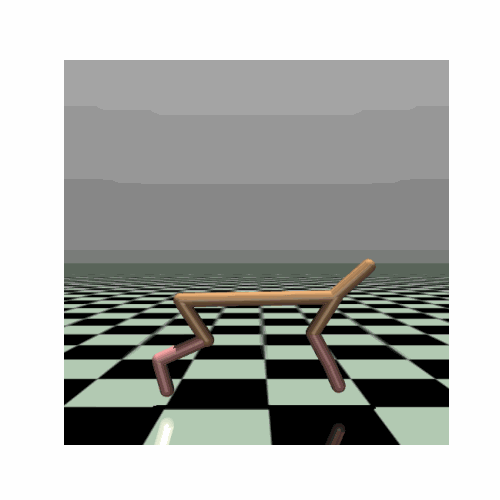

In [13]:
bc_policy.load_state_dict(torch.load('bc_policy.pth')['state_dict'])
frames, total_reward = demo_policy(bc_policy, environment_name=ENVIRONMENT_NAME, steps=200)
gif_path = save_frames_as_gif(frames, method_name='bc')
Image(open(gif_path,'rb').read())

<!-- ### Part 2 - DAgger

BC is great at replicating supervisor actions when the agent is in the data distribution, but this assumption is not always true. Sometimes the agent may enter an out of distribution state and output bad actions. A popular method to handle this issue is [Dataset Aggregation (DAgger)](https://arxiv.org/abs/1011.0686). The key idea behind DAgger is to roll out the learned policy while querying an expert policy on the states the agent encounters, adding the state-expert action pairs to the dataset.

Luckily for you, we're providing an expert pretrained using the Soft Actor Critic Algorithm, which we'll load and test in the following block. -->

### Part 2 - Implicit Q Learning

In this part you'll implement Implicit Q-Learning (Kostrikov et al., 2021), a popular offline RL algorithm.

The key idea behind IQL is to use expectile regression to optimize the value functions so that they estimate the values of the higher-performing actions in the dataset, rather than estimating the values of the current policy. This allows you to learn a value function without ever querying the policy, which helps to avoid OOD issues. We would suggest having a look at Kostrikov et al. for a more thorough description of the algorithm.

To start, implement a double Q function below. This can be similar to the code from HW1 but notice the constructor has a different signature.

In [16]:
from src.networks import GaussianPolicy

################################## Hyper-parameters #########################################

EPOCHS: int = 50
EVAL_FREQ = 5
LOAD_CKPT = False

hidden_dim: int = 256
n_hidden: int = 3
lr: float = 3e-4
WEIGHT_DECAY: float = 3e-4

#############################################################################################

bc_policy = GaussianPolicy(state_dimension, action_dimension, hidden_dim, n_hidden).to(DEVICE)
optimizer = Adam(bc_policy.parameters(), lr)


In [17]:
from src.networks import network

class QNetwork(nn.Module):
    def __init__(self, state_dimension, action_dimension, hidden_dim, n_hidden):
        super(QNetwork, self).__init__()

        # TODO: fill in your code here
        self.q1 = network(state_dimension + action_dimension, 1, hidden_dim, n_hidden)
        self.q2 = network(state_dimension + action_dimension, 1, hidden_dim, n_hidden)

    def forward(self, state, action):

        # TODO: fill in your code here to query the critic

        state_action = torch.cat([state, action], dim=-1)

        # Compute Q-values from both networks
        q1 = self.q1(state_action).squeeze(-1)  # Removing last dimension to get shape [batch_size]
        q2 = self.q2(state_action).squeeze(-1)  # Removing last dimension to get shape [batch_size]


        return q1, q2

Next, implement a value network below. This should be similar to the Q network, but only condition on states and should only have one network.

In [18]:
class VNetwork(nn.Module):
    def __init__(self, state_dimension, hidden_dim, n_hidden):
        super(VNetwork, self).__init__()

        # TODO: your code here
        self.v_net = network(state_dimension, 1, hidden_dim, n_hidden)

    def forward(self, state):

        # TODO: your code here
        v = self.v_net(state).squeeze(-1)
        return v

Next, implement the expectile loss, $L^{\tau}_2$, to be used for optimizing the value function. This function is described in Sections 4.1 of Kostrikov et al.

In [19]:
def expectile_loss(diff, expectile=0.8):
    # TODO: fill in this function
    weight = torch.where(diff > 0, 1 - expectile, expectile)
    return (weight * diff ** 2).mean()

Finally, it's time to implement the IQL training loop. There are several steps here:
 * Implement the value function update using the `expectile_loss` function implemented above.
 * Implement the $Q$ function update. The targets for this update should be a bellman backup based on the value function. Don't forget to update the EMA target!
 * Implement the policy update. This should be an NLL loss weighted based on clipped exponentiated advantage estimates

More details about all of these steps can be found in Kostrikov et al.

Once you've finished implementing the training loop run the cell to train your IQL policy. Your policy should get reward greater than 0.4 with a correct implementation and hyperparameters.

<ipython-input-20-8e9bb09354ee>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('iql_checkpoint.pth')


Resuming run from epoch 119


  0%|          | 0/789 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|██████████| 789/789 [00:07<00:00, 103.84it/s]
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Epoch: 120. Q Loss: 166674.5739. V Loss: 19644.7565. P Loss: 540.6993. Reward: 0.0225 +/- 0.0001


100%|██████████| 789/789 [00:06<00:00, 115.80it/s]


Epoch: 135. Q Loss: 6206.8133. V Loss: 719.6076. P Loss: 506.8829. Reward: 0.0225 +/- 0.0001


100%|██████████| 789/789 [00:05<00:00, 134.15it/s]


Epoch: 150. Q Loss: 6116.4171. V Loss: 704.3538. P Loss: 522.0402. Reward: 0.0225 +/- 0.0001


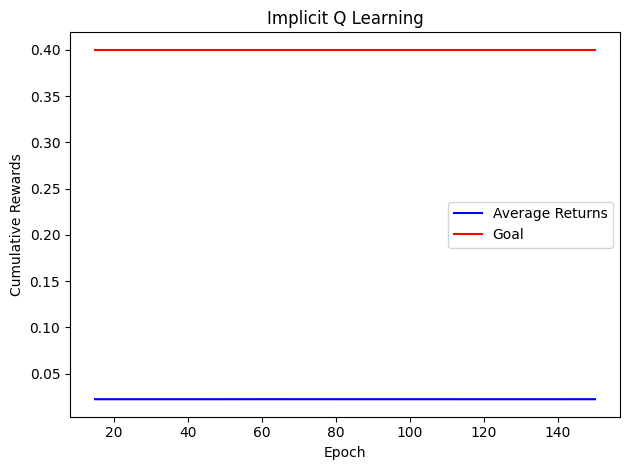

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
EPOCHS = 150
EVAL_FREQ = 15
LOAD_FROM_CKPT = True

# These parameters should work fine but you may tune them if you want to
hidden_dim: int = 256
n_hidden: int = 2
lr: float = 3e-4
discount = 0.99
alpha = 0.005
exp_advantage_max = 100

# TODO: you'll need to choose your own value for the following parameters
tau = 0.7
beta = 1.0

min_rew, max_rew = return_range(dataset, 1000)

#############################################################################################

sampler = D4RLSampler(dataset, 256, DEVICE)

iql_policy = GaussianPolicy(state_dimension, action_dimension, hidden_dim, n_hidden).to(DEVICE)
policy_optimizer = Adam(iql_policy.parameters(), lr)
policy_lr_schedule = CosineAnnealingLR(policy_optimizer, EPOCHS * len(sampler))

v_critic = VNetwork(state_dimension, hidden_dim, n_hidden).to(DEVICE)
v_optimizer = Adam(v_critic.parameters(), lr)

q_critic = QNetwork(state_dimension, action_dimension, hidden_dim, n_hidden).to(DEVICE)
q_critic_target = copy.deepcopy(q_critic)
q_critic_target.requires_grad_(False)
q_optimizer = Adam(q_critic.parameters(), lr)

means, stds, start_epoch = [], [], 0
if os.path.exists('iql_checkpoint.pth') and LOAD_FROM_CKPT:
    checkpoint = torch.load('iql_checkpoint.pth')

    iql_policy.load_state_dict(checkpoint['iql_policy'])
    policy_optimizer.load_state_dict(checkpoint['policy_optimizer'])
    v_critic.load_state_dict(checkpoint['v_critic'])
    v_optimizer.load_state_dict(checkpoint['v_optimizer'])
    q_critic.load_state_dict(checkpoint['q_critic'])
    q_critic_target.load_state_dict(checkpoint['q_critic_target'])
    q_optimizer.load_state_dict(checkpoint['q_optimizer'])

    start_epoch = checkpoint['epoch']
    means = checkpoint['means']
    stds = checkpoint['stds']

    print(f'Resuming run from epoch {start_epoch}')

for epoch in range(start_epoch, EPOCHS):
    total_q_loss = total_v_loss = total_policy_loss = count = 0
    policy_losses = []
    # for batch in tqdm(dataloader):
    for batch in tqdm(sampler):
        state = batch['state'].to(DEVICE)
        next_state = batch['next_state'].to(DEVICE)
        action = batch['action'].to(DEVICE)
        reward = einops.rearrange(batch['reward'], 'b -> b 1').to(DEVICE)
        reward = reward / (max_rew - min_rew) * 1000
        not_done = einops.rearrange(batch['not_done'], 'b -> b 1').to(DEVICE)

        # # TODO: update the state value function (V)
        # v_loss = torch.tensor(0)

        # # TODO: update the state-action value function (Q) and the target
        # q_loss = torch.tensor(0)

        # # TODO: update the policy
        # policy_loss = torch.tensor(0)

        # -----------------
        # Value Function Update
        # -----------------
        with torch.no_grad():
            # Compute target value using Q-values
            q1, q2 = q_critic(state, action)
            target_v = torch.min(q1, q2)

        v_pred = v_critic(state)  # Predict value from V-network
        v_loss = expectile_loss(target_v - v_pred, expectile=tau)

        v_optimizer.zero_grad()
        v_loss.backward()
        v_optimizer.step()
        total_v_loss += v_loss.item()

        # -----------------
        # Q Function Update
        # -----------------
        with torch.no_grad():
            # Compute Bellman target for Q update
            v_next = v_critic(next_state)
            target_q = reward + discount * not_done * v_next

        q1, q2 = q_critic(state, action)
        q_loss = ((q1 - target_q) ** 2 + (q2 - target_q) ** 2).mean()

        q_optimizer.zero_grad()
        q_loss.backward()
        q_optimizer.step()
        total_q_loss += q_loss.item()

        # EMA target update
        for param, target_param in zip(q_critic.parameters(), q_critic_target.parameters()):
            target_param.data.copy_(alpha * param.data + (1 - alpha) * target_param.data)

        # -----------------
        # Policy Update
        # -----------------
        with torch.no_grad():
            # Compute the advantage and exponentiate it
            q1, q2 = q_critic(state, action)
            v_pred = v_critic(state)
            adv = torch.min(q1, q2) - v_pred
            weights = torch.clamp(torch.exp(adv / beta), max=exp_advantage_max)

        policy_dist = iql_policy.pi(state)
        log_prob = policy_dist.log_prob(action).sum(-1)  # Sum log probs across action dimensions
        policy_loss = -(weights * log_prob).mean()  # Weighted NLL loss

        policy_lr_schedule.step()
        total_v_loss += v_loss.item()
        total_q_loss += q_loss.item()
        total_policy_loss += policy_loss.item()
        count += 1

    if (epoch + 1) % EVAL_FREQ == 0:
        rew_mean, rew_std = eval_policy(iql_policy, environment_name=ENVIRONMENT_NAME, eval_episodes=50)
        print(f'Epoch: {epoch + 1}. Q Loss: {total_q_loss / count:.4f}. V Loss: {total_v_loss / count:.4f}. P Loss: {total_policy_loss / count:.4f}. Reward: {rew_mean:.4f} +/- {rew_std:.4f}')
        means.append(rew_mean)
        stds.append(rew_std)

    # Save a checkpoint so that you can resume training if it crashes
    checkpoint = {
        'iql_policy': iql_policy.state_dict(),
        'policy_optimizer': policy_optimizer.state_dict(),
        'v_critic': v_critic.state_dict(),
        'v_optimizer': v_optimizer.state_dict(),
        'q_critic': q_critic.state_dict(),
        'q_critic_target': q_critic_target.state_dict(),
        'q_optimizer': q_optimizer.state_dict(),
        'epoch': epoch + 1,
        'means': means,
        'stds': stds
    }
    torch.save(checkpoint, 'iql_checkpoint.pth')

epochs = np.arange(EVAL_FREQ, EPOCHS + EVAL_FREQ, step=EVAL_FREQ)
plot_returns(means, stds, 'Implicit Q Learning', goal=0.4, epochs=epochs)

Now that we've finished training our IQL policy we can visualize it in the block below.

<ipython-input-21-2983616a8d9a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  iql_policy.load_state_dict(torch.load('iql_checkpoint.pth')['iql_policy'])
100%|██████████| 

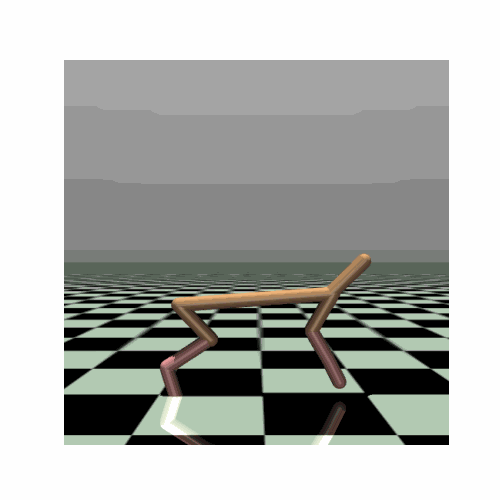

In [21]:
iql_policy.load_state_dict(torch.load('iql_checkpoint.pth')['iql_policy'])
frames, total_reward = demo_policy(iql_policy, environment_name=ENVIRONMENT_NAME, steps=200)
gif_path = save_frames_as_gif(frames, method_name='iql')
Image(open(gif_path,'rb').read())

Congrats on finishing the offline portion of Assignment 2! Hopefully you enjoyed yourself. Make sure that the visualizations are showing and that there are four outputs from this notebook in the artifacts folder:
 * `bc_policy.gif`
 * `iql_policy.gif`
 * `Behavior Cloning_returns.png`
 * `Implicit Q Learning_results.png`

When you're done: export this notebook as an **HTML file** for final submission.